In [226]:
%load_ext autoreload
%autoreload 2
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm.notebook import tqdm

from dynamics import LDS
from koopman import KoopmanNetwork
import utils

RNG = default_rng()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


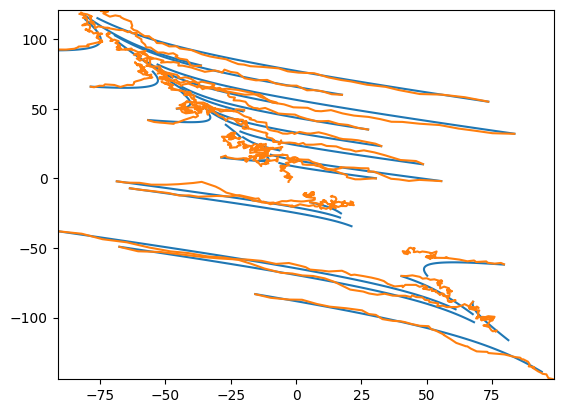

In [307]:
"""
input dimension = dimension of the raw data (potentially very large)
intrinsic dimension = dimension of the underlying dynamics data
"""
intrinsic_dim = 2
A = RNG.integers(low=-4, high=4, size=(intrinsic_dim, intrinsic_dim))
init_conds = RNG.integers(low=-100, high=100, size=(5000, intrinsic_dim))
lds = LDS(A, init_conds, noise_var=1)
utils.plot([lds.trajs, lds.noisy_trajs])

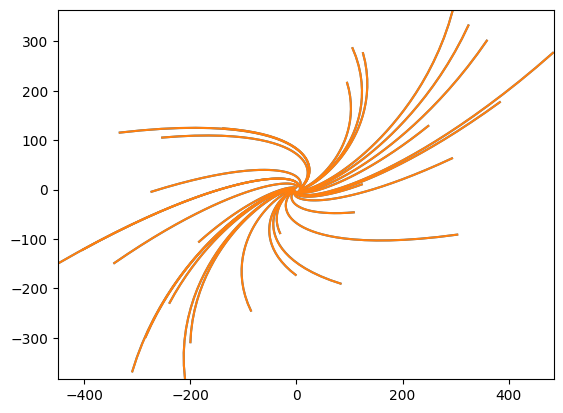

In [294]:
input_dim = 2
W = RNG.integers(low=-5, high=5, size=(intrinsic_dim, input_dim))
trans_trajs = np.array([traj @ W for traj in lds.trajs])
trans_noisy_trajs = np.array([traj @ W for traj in lds.noisy_trajs])
pca = utils.make_pca(trans_trajs, n_components=min(intrinsic_dim, 3))
utils.plot([trans_trajs, trans_noisy_trajs], pca=pca)

In [295]:
network = KoopmanNetwork(input_dim=input_dim, intrinsic_dim=intrinsic_dim,
                         encoder_hidden_widths=(10, 10),
                         decoder_hidden_widths=(10, 10), activation="relu")

Epoch 1/100
50/50 [==============================] - 1s 8ms/step - loss: 8415.7783
Epoch 2/100
50/50 [==============================] - 0s 7ms/step - loss: 6792.8882
Epoch 3/100
50/50 [==============================] - 0s 7ms/step - loss: 5440.2578
Epoch 4/100
50/50 [==============================] - 0s 7ms/step - loss: 4981.2246
Epoch 5/100
50/50 [==============================] - 0s 7ms/step - loss: 3512.7988
Epoch 6/100
50/50 [==============================] - 0s 7ms/step - loss: 1677.1783
Epoch 7/100
50/50 [==============================] - 0s 7ms/step - loss: 1551.8866
Epoch 8/100
50/50 [==============================] - 0s 7ms/step - loss: 1234.9672
Epoch 9/100
50/50 [==============================] - 0s 7ms/step - loss: 564.1566
Epoch 10/100
50/50 [==============================] - 0s 6ms/step - loss: 223.8255
Epoch 11/100
50/50 [==============================] - 0s 7ms/step - loss: 115.8077
Epoch 12/100
50/50 [==============================] - 0s 7ms/step - loss: 79.1211
Epoch 

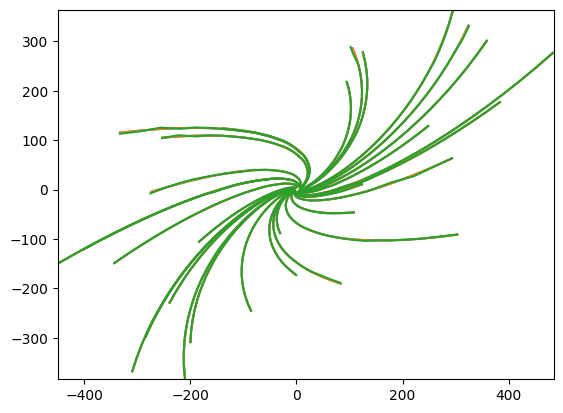

In [296]:
network.train_autoencoder(trans_noisy_trajs, epochs=100, batch_size=100)
autoencoded_trajs = network.autoencoder_predict(trans_noisy_trajs)
utils.plot([trans_trajs, trans_noisy_trajs, autoencoded_trajs], pca=pca)

157/157 [==============================] - 10s 4ms/step


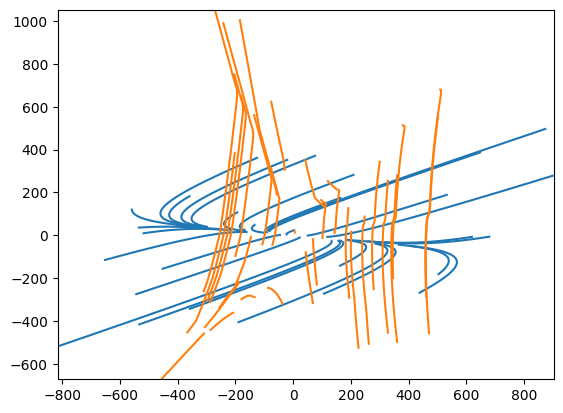

In [255]:
network.train_model(trans_noisy_trajs, epochs=1, batch_size=100)
pred_trajs = network.model_predict(trans_trajs[:, 0, :])  # no noise is added to the initial condition, so it doesn't matter if we use the noisy or true trajectories here
utils.plot([trans_trajs, pred_trajs], pca=pca)

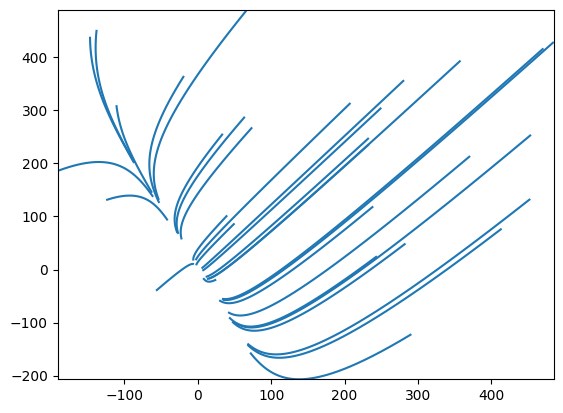

In [256]:
lds_test = LDS(A, init_conds=RNG.integers(low=-200, high=500, size=(30, intrinsic_dim)))
utils.plot([lds_test.trajs], pca=pca)

In [257]:
predicted_A = network._koopman.layers[-1].kernel.numpy()
predicted_A

array([[-0.36928686, -0.04246964],
       [-1.070553  ,  1.0577863 ]], dtype=float32)

In [259]:
A_eigenvalues, A_eigenvectors = np.linalg.eig(A)
np.sort(A_eigenvalues)

array([-4.30277564, -0.69722436])

In [258]:
predicted_eigenvalues, predicted_eigenvectors = np.linalg.eig(predicted_A)
np.sort(predicted_eigenvalues)

array([-0.4004653,  1.0889648], dtype=float32)

In [289]:
tf.reduce_mean(tf.keras.losses.MSE(trans_noisy_trajs, autoencoded_trajs))

<tf.Tensor: shape=(), dtype=float32, numpy=0.6655085>

In [284]:
print(f"{np.average(trans_trajs - trans_noisy_trajs) * 1000=}")
print(f"{np.average(trans_trajs - autoencoded_trajs) * 1000=}")
print(f"{np.average(trans_noisy_trajs - autoencoded_trajs) * 1000=}")

np.average(trans_trajs - trans_noisy_trajs) * 1000=0.007432634586510776
np.average(trans_trajs - autoencoded_trajs) * 1000=-3.479165874740556
np.average(trans_noisy_trajs - autoencoded_trajs) * 1000=-3.486598509327066
